# Wolfram Marlowe Smart Contract Execution - Milestone 1

### Executive Summary

We show the operation of a specific-purpose oracle validator tailored to provide finantial information for Marlowe contracts through a `Choice` Input. There are two steps to be performed.

#### 1. Contract Deployment 
User allocates the payment and provides information about their Marlowe contract and requested data. 
The datum schema also includes refund parameters in the following structure

```
oracleDatum = {
       transactionId :: TxId,
       transactionIndex :: Integer,
       choiceToSolve :: BuiltinByteString,
       dataTag :: BuiltinByteString,
       deadline:: POSIXTime,
       beneficiary:: PubKeyHash
}
```

where `transactionId` and `transactionIndex` identify the marlowe contract awaiting for a choice, `choiceToSolve` is the name of the choice in the Marlowe contract context and `dataTag` . The last two fields are required to validate the timeout policy and will be explained later.

The deployment diagrams is showed.
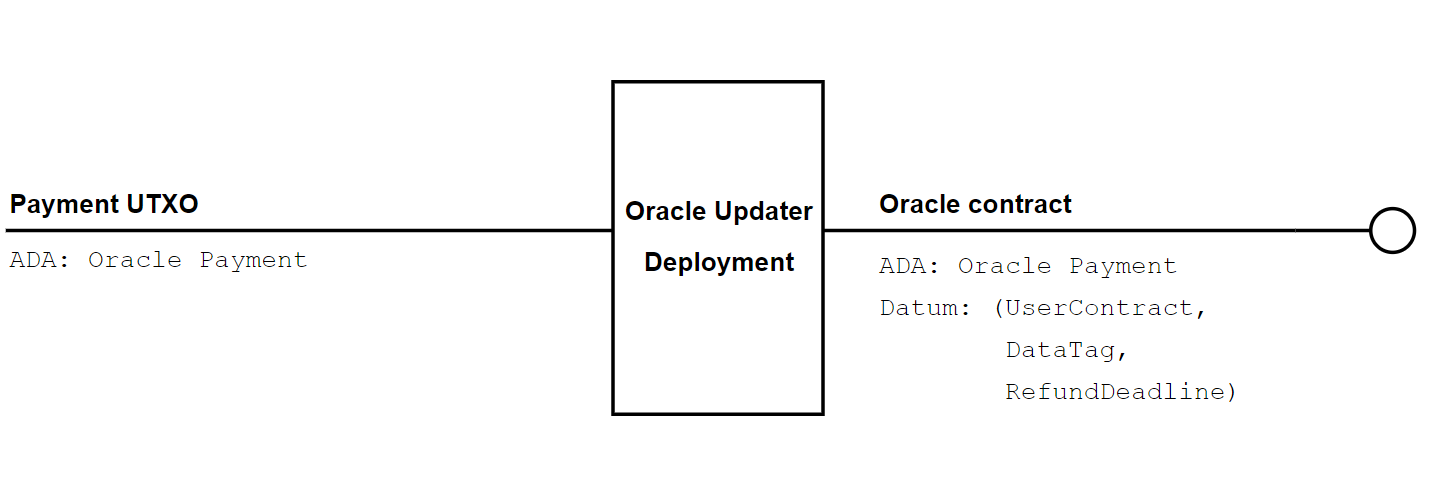

#### 2. Oracle Choice Transaction
The oracle consumes the previous UTXO and applies the choice with the requested data. When making a choice the validator does the following verifications:

* Choice is made before deadline limit
* Marlowe contract (TxId and TxIdx) is present in the transaction context
* Marlowe redeemer “ChoiceName” is equal to “choiceToSolve”

If the contract isn’t redeemed by the deadline, the ADA becomes available to the beneficiary, who can use it by presenting their signature in a transaction as a required signer.

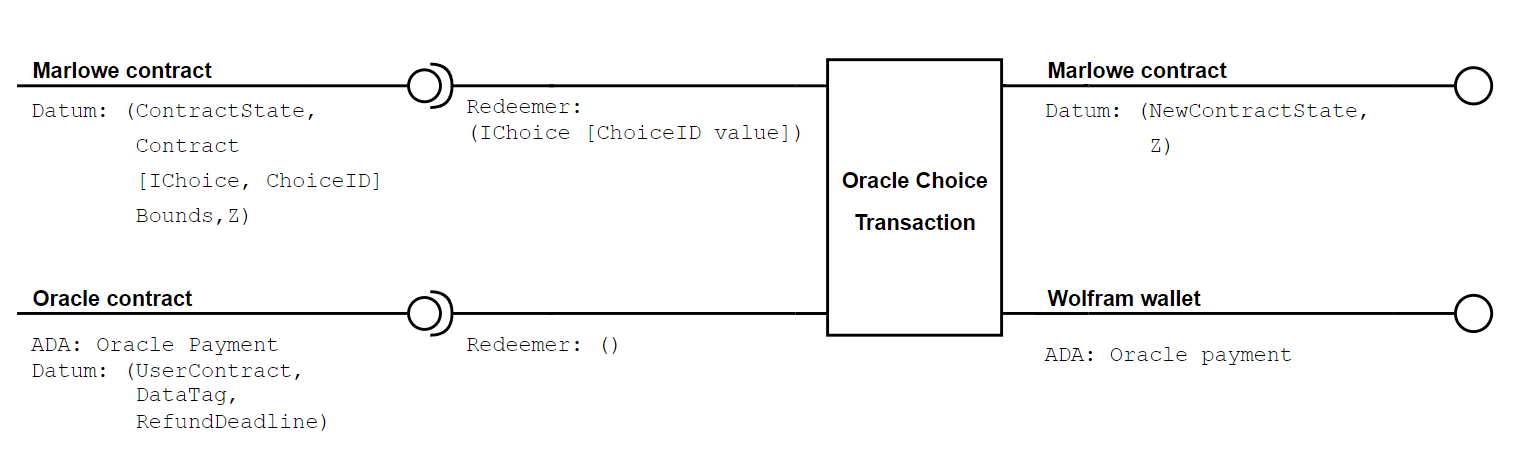

## Contract Execution


### Marlowe Starter Kit Tools

### Utilities

Function to select a UTXO based on a minimun quantity.

In [7]:
function select_utxo {
marlowe-cli util select \
  --testnet-magic 1 \
  --lovelace-only "$1" \
  "$PAYMENT_ADDR" \
| sed -n -e 's/^TxIn "\(.*\)" (TxIx \(.*\))$/\1#\2/;1p'
}

### Credentials

In [8]:
export KEYS=./credentials
PAYMENT_SKEY=$KEYS/lender.skey
PAYMENT_ADDR=$(cat $KEYS/lender.address)
echo "PAYMENT_ADDR=$PAYMENT_ADDR"

PAYMENT_ADDR=addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l


### Constants

In [9]:
ADA=1000000

### POSIX Milliseconds and Slots

The constants provided by the marlowe-cli slotting utility will help us calculate the validity interval for the transactions.

In [10]:
SLOT_LENGTH=$(marlowe-cli util slotting | jq -r .scSlotLength)
SLOT_ZERO_TIME=$(marlowe-cli util slotting | jq -r .scSlotZeroTime)
echo "SLOT_LENGTH = $SLOT_LENGTH"
echo "SLOT_ZERO_TIME = $SLOT_ZERO_TIME"

SLOT_LENGTH = 1000
SLOT_ZERO_TIME = 1655683200000


### Unit File
This file will be used as redeemer for the wolframOracleUpdater contract.

In [11]:
yaml2json << EOI > unit.json
constructor: 0
fields: []
EOI
cat unit.json

{"constructor":0,"fields":[]}


## Marlowe contract preparation

### Initial Contract

As demonstration we use a simple marlowe contract that receives a deposit, waits for a choice and closes with a notification.

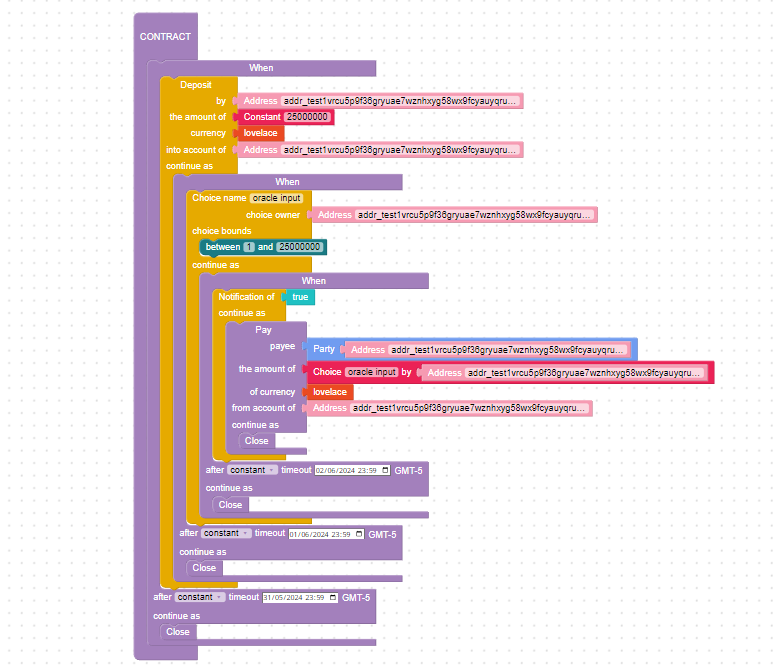

### Marlowe Validator Address

In [ ]:
marlowe-cli contract validator \
  --testnet-magic 1 \
  --out-file /dev/null \
  --print-hash

In [ ]:
MARLOWE_ADDR=$(marlowe-cli contract address --testnet-magic 1 )
echo "MARLOWE_ADDR = $MARLOWE_ADDR"

In [ ]:
UTXO_MARLOWE_SCRIPT=$(
marlowe-cli transaction find-published \
   --testnet-magic 1 \
  2> /dev/null \\
| jq -r .marlowe.txIn
)
echo $UTXO_MARLOWE_SCRIPT

### Contract
We define the deadlines for each action in the contract and create the .contract file.

In [ ]:
PAYMENT_DEADLINE=$((1000 * $(date -d "$(date -u) + 8 days" +%s))) #deadline
CHOICE_DEADLINE=$((1000 * $(date -d "$(date -u) + 9 days" +%s))) #deadline
NOTIFY_DEADLINE=$((1000 * $(date -d "$(date -u) + 10 days" +%s))) #deadline

In [ ]:
yaml2json << EOI > tx-1.contract
timeout: $PAYMENT_DEADLINE
timeout_continuation: close
when:
- case:
    deposits: 25000000
    into_account:
      address: $PAYMENT_ADDR
    of_token:
      currency_symbol: ''
      token_name: ''
    party:
      address: $PAYMENT_ADDR
  then:
    timeout: $CHOICE_DEADLINE
    timeout_continuation: close
    when:
    - case:
        choose_between:
        - from: 1
          to: 25000000
        for_choice:
          choice_name: oracle input
          choice_owner:
            address: $PAYMENT_ADDR
      then:
        timeout: $NOTIFY_DEADLINE
        timeout_continuation: close
        when:
        - case:
            notify_if: true
          then:
            from_account:
              address: $PAYMENT_ADDR
            pay:
              value_of_choice:
                choice_name: oracle input
                choice_owner:
                  address: $PAYMENT_ADDR
            then: close
            to:
              party:
                address: $PAYMENT_ADDR
            token:
              currency_symbol: ''
              token_name: ''
EOI
json2yaml tx-1.contract

### State

The initial state only needs the initial ADA and one address.

In [ ]:
INITIAL_LOVELACE=$((3 * ADA))

In [ ]:
yaml2json << EOI > tx-1.state
accounts:
- - - address: $PAYMENT_ADDR
    - currency_symbol: ''
      token_name: ''
  - $INITIAL_LOVELACE
boundValues: []
choices: []
minTime: 1
EOI
cat tx-1.state

## Transaction 1: Marlowe Contract Creation

We construct the transactions manually since Marlowe's available tools do not support including auxiliary inputs and outputs. The datums and redeemers are created with marlowe-cli.

In [ ]:
marlowe-cli run initialize \
  --contract-file tx-1.contract \
  --state-file tx-1.state \
  --out-file tx-1.marlowe

In [ ]:
marlowe-cli contract datum \
  --contract-file tx-1.contract \
  --state-file tx-1.state \
  --out-file tx-1.datum

In [ ]:
#we select the first input manually.
TX_1_IN="$(select_utxo $((100 * ADA)))"
echo "TX_1_IN = $TX_1_IN"

Build and submit the contract creation transaction.

In [ ]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in $TX_1_IN \
  --tx-out "$MARLOWE_ADDR+$INITIAL_LOVELACE" \
    --tx-out-datum-embed-file tx-1.datum \
  --change-address $PAYMENT_ADDR \
  --out-file tx-1.unsigned

In [ ]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-1.unsigned \
  --out-file tx-1.signed

In [ ]:
TX_1=$(cardano-cli transaction txid --tx-file tx-1.signed)
echo "TX_1 = $TX_1"

In [ ]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-1.signed

## Transaction 2: Marlowe Deposit

Now, the deposit step is executed and the contract status moves forward to the choice step.

In [ ]:
DEPOSIT_LOVELACE=$((25 * ADA))

In [ ]:
TX_2_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_2_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_2_INVALID_BEFORE = $TX_2_INVALID_BEFORE"
echo "TX_2_INVALID_HEREAFTER = $TX_2_INVALID_HEREAFTER"

In [ ]:
marlowe-cli run prepare \
  --deposit-account $PAYMENT_ADDR \
  --deposit-party $PAYMENT_ADDR \
  --deposit-amount $DEPOSIT_LOVELACE \
  --invalid-before $TX_2_INVALID_BEFORE \
  --invalid-hereafter $TX_2_INVALID_HEREAFTER \
  --marlowe-file tx-1.marlowe \
  --out-file tx-2.marlowe

In [ ]:
jq '.tx.inputs[0]' tx-2.marlowe > tx-2.inputs
marlowe-cli contract redeemer \
  --input-file tx-2.inputs \
  --out-file tx-2.redeemer

In [ ]:
jq .tx.contract tx-2.marlowe > tx-2.contract
jq .tx.state tx-2.marlowe > tx-2.state
marlowe-cli contract datum \
  --contract-file tx-2.contract \
  --state-file tx-2.state \
  --out-file tx-2.datum

In [ ]:
DEPOSIT_INPUT="$TX_1#1"
echo "DEPOSIT_INPUT = $DEPOSIT_INPUT"

Build and submit the deposit transaction.

In [ ]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$DEPOSIT_INPUT" \
  --tx-in "$DEPOSIT_INPUT" \
  --tx-in "$TX_1#0" \
    --spending-tx-in-reference "$UTXO_MARLOWE_SCRIPT" \
    --spending-plutus-script-v2 \
    --spending-reference-tx-in-datum-file tx-1.datum \
    --spending-reference-tx-in-redeemer-file tx-2.redeemer \
  --tx-out "$MARLOWE_ADDR+$((INITIAL_LOVELACE+DEPOSIT_LOVELACE))" \
    --tx-out-datum-embed-file tx-2.datum \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_2_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_2_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-2.unsigned

In [ ]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-2.unsigned \
  --out-file tx-2.signed

In [ ]:
## this is the transaction that must be solved
TX_2=$(cardano-cli transaction txid --tx-file tx-2.signed)
echo "TX_2 = $TX_2"

In [ ]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-2.signed

## Transaction 3: Oracle Updater Deployment
### Oracle Contract Address and Payment

We define the contract address and how much ADA it will hold as payment for the service.

In [ ]:
ORACLE_ADDR=$(cardano-cli address build --testnet-magic 1 --payment-script-file wolframOracleUpdater.plutus)
echo "ORACLE_ADDR = $ORACLE_ADDR"

In [ ]:
ORACLE_PAYMENT=$((5 * ADA))
echo "ORACLE_PAYMENT=$ORACLE_PAYMENT"

### Create "oracle.datum" File

Next, we define the datum which contains information for the oracle choice execution. Below we provide a simple constructor for this particular contract.

In [ ]:
TX_ID=$TX_2 #tx to be solved
TX_IDX=0    #index to be solved
ORACLE_DL=$((1000 * $(date -d "$(date -u) + 90 minutes" +%s))) #deadline to apply choice before refund
echo "TX_ID=$TX_ID"
echo "TX_IDX=$TX_IDX"
echo "ORACLE_DL=$ORACLE_DL"

In [ ]:
yaml2json << EOI > wolframOracleUpdater.datum
constructor: 0
fields:
- constructor: 0
  fields:
  - bytes: "$TX_ID"
- int: $TX_IDX
- bytes: "6f7261636c6520696e707574" #oracle input
- bytes: "414441555344"             #adausd
- int: $ORACLE_DL
- bytes: "f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"
EOI
cat wolframOracleUpdater.datum

### Build Transaction

Now we build and submit the Oracle Updater creation transaction.

In [ ]:
ORACLE_INPUT="$TX_2#1"
echo $ORACLE_INPUT

In [ ]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in "$ORACLE_INPUT" \
  --tx-out "$ORACLE_ADDR+$ORACLE_PAYMENT" \
    --tx-out-datum-embed-file oracle.datum \
  --change-address $PAYMENT_ADDR \
  --out-file tx-3.unsigned

In [ ]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-3.unsigned \
  --out-file tx-3.signed

In [ ]:
TX_3=$(cardano-cli transaction txid --tx-file tx-3.signed)
echo "TX_3 = $TX_3"

In [ ]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-3.signed

## Transaction 4: Oracle Choice Transaction

Here we consume both contracts in the same transaction.

In [ ]:
CHOICE=$((15 * ADA))
echo "CHOICE = $CHOICE"

In [ ]:
TX_4_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_4_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_4_INVALID_BEFORE = $TX_4_INVALID_BEFORE"
echo "TX_4_INVALID_HEREAFTER = $TX_4_INVALID_HEREAFTER"

In [ ]:
marlowe-cli run prepare \
  --choice-name "oracle input" \
  --choice-party $PAYMENT_ADDR \
  --choice-number $CHOICE \
  --invalid-before $TX_4_INVALID_BEFORE \
  --invalid-hereafter $TX_4_INVALID_HEREAFTER \
  --marlowe-file tx-2.marlowe \
  --out-file tx-4.marlowe

In [ ]:
jq '.tx.inputs[0]' tx-4.marlowe > tx-4.inputs
marlowe-cli contract redeemer \
  --input-file tx-4.inputs \
  --out-file tx-4.redeemer

In [ ]:
jq .tx.contract tx-4.marlowe > tx-4.contract
jq .tx.state tx-4.marlowe > tx-4.state
marlowe-cli contract datum \
  --contract-file tx-4.contract \
  --state-file tx-4.state \
  --out-file tx-4.datum

In [ ]:
CHOICE_INPUT="$TX_3#1"
echo "CHOICE_INPUT=$CHOICE_INPUT"

Now we build and submit the choice transaction.

In [ ]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$CHOICE_INPUT" \
  --tx-in "$CHOICE_INPUT" \
  --tx-in "$TX_2#0" \
    --spending-tx-in-reference "$UTXO_MARLOWE_SCRIPT" \
    --spending-plutus-script-v2 \
    --spending-reference-tx-in-datum-file tx-2.datum \
    --spending-reference-tx-in-redeemer-file tx-4.redeemer \
  --tx-in "$TX_3#0" \
    --tx-in-script-file wolframOracleUpdater.plutus \
    --tx-in-datum-file wolframOracleUpdater.datum \
    --tx-in-redeemer-file unit.json \
  --tx-out "$MARLOWE_ADDR+$((INITIAL_LOVELACE+DEPOSIT_LOVELACE))" \
    --tx-out-datum-embed-file tx-4.datum \
  --tx-out "$PAYMENT_ADDR+$((ORACLE_PAYMENT))" \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_4_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_4_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-4.unsigned

In [ ]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-4.unsigned \
  --out-file tx-4.signed

In [ ]:
TX_4=$(cardano-cli transaction txid --tx-file tx-4.signed)
echo "TX_4 = $TX_4"

In [ ]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-4.signed

## Transaction 5: Notify and Close Marlowe Contract

Finally the Marlowe contract ends with a `Notify` input.

In [ ]:
TX_5_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_5_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_5_INVALID_BEFORE = $TX_5_INVALID_BEFORE"
echo "TX_5_INVALID_HEREAFTER = $TX_5_INVALID_HEREAFTER"

In [ ]:
marlowe-cli run prepare \
  --notify \
  --invalid-before $TX_5_INVALID_BEFORE \
  --invalid-hereafter $TX_5_INVALID_HEREAFTER \
  --marlowe-file tx-4.marlowe \
  --out-file tx-5.marlowe

In [ ]:
jq '.tx.inputs[0]' tx-5.marlowe > tx-5.inputs
marlowe-cli contract redeemer \
  --input-file tx-5.inputs \
  --out-file tx-5.redeemer

In [ ]:
jq .tx.contract tx-5.marlowe > tx-5.contract
jq .tx.state tx-5.marlowe > tx-5.state
marlowe-cli contract datum \
  --contract-file tx-4.contract \
  --state-file tx-4.state \
  --out-file tx-4.datum

In [ ]:
NOTIFY_INPUT="$TX_4#2"
echo "NOTIFY_INPUT=$NOTIFY_INPUT"

In [ ]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$NOTIFY_INPUT" \
  --tx-in "$NOTIFY_INPUT" \
  --tx-in "$TX_4#0" \
    --spending-tx-in-reference "$UTXO_MARLOWE_SCRIPT" \
    --spending-plutus-script-v2 \
    --spending-reference-tx-in-datum-file tx-4.datum \
    --spending-reference-tx-in-redeemer-file tx-5.redeemer \
  --tx-out "$PAYMENT_ADDR+$CHOICE" \
  --tx-out "$PAYMENT_ADDR+$((INITIAL_LOVELACE+DEPOSIT_LOVELACE-CHOICE))" \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_5_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_5_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-5.unsigned

In [ ]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-5.unsigned \
  --out-file tx-5.signed

In [ ]:
TX_5=$(cardano-cli transaction txid --tx-file tx-5.signed)
echo "TX_5 = $TX_5"

In [ ]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-5.signed

## Timeout Policy

We have seen the contract operation in a normal workflow. The choice is made and the payment allocated is redirected to the oracle wallet. Since the payment is locked in a script, we have implemented a devolution policy in case of failure.

We return to the last two fields in the datum

```
oracleDatum = {
       transactionId :: TxId,
       transactionIndex :: Integer,
       choiceToSolve :: BuiltinByteString,
       dataTag :: BuiltinByteString,
       deadline:: POSIXTime,
       beneficiary:: PubKeyHash
}
```

where `deadline` marks the time limit to fullfil the request by making a choice. After that time, the ADA locked in the oracle UTXO can be used by stating the UTXO as input and the `beneficiary` as required signer.

## Transaction 6: Deploy Oracle with Small Deadline

In [12]:
ORACLE_ADDR=$(cardano-cli address build --testnet-magic 1 --payment-script-file wolframOracleUpdater.plutus)
echo "ORACLE_ADDR = $ORACLE_ADDR"

ORACLE_ADDR = addr_test1wrndcvjv0eh4h6z4542pshfd84sa9dxpz0neztq6rppwvwg2h9054


In [13]:
TX_ID=$TX_2 #tx to be solved
TX_IDX=0    #index to be solved
ORACLE_DL=$((1000 * $(date -d "$(date -u) + 5 minutes" +%s))) #deadline to apply choice before refund
echo "TX_ID=$TX_ID"
echo "TX_IDX=$TX_IDX"
echo "ORACLE_DL=$ORACLE_DL"

TX_ID=
TX_IDX=0
ORACLE_DL=1716857874000


In [14]:
yaml2json << EOI > wolframOracleUpdater.datum
constructor: 0
fields:
- constructor: 0
  fields:
  - bytes: "$TX_ID"
- int: $TX_IDX
- bytes: "6f7261636c6520696e707574" #oracle input
- bytes: "414441555344"             #adausd
- int: $ORACLE_DL
- bytes: "f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"
EOI
cat wolframOracleUpdater.datum

{"constructor":0,"fields":[{"constructor":0,"fields":[{"bytes":""}]},{"int":0},{"bytes":"6f7261636c6520696e707574"},{"bytes":"414441555344"},{"int":1716857874000},{"bytes":"f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"}]}


In [16]:
ORACLE_INPUT="$(select_utxo $((100 * ADA)))"
echo "ORACLE_INPUT=$ORACLE_INPUT"

ORACLE_INPUT=78d0edfb27cf3fcd47312df473c4d91649e708396965ab24fbb40c073cfd5919#2


In [17]:
ORACLE_PAYMENT=$((5 * ADA))
echo "ORACLE_PAYMENT=$ORACLE_PAYMENT"

ORACLE_PAYMENT=5000000


In [18]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in "$ORACLE_INPUT" \
  --tx-out "$ORACLE_ADDR+$ORACLE_PAYMENT" \
    --tx-out-datum-embed-file wolframOracleUpdater.datum \
  --change-address $PAYMENT_ADDR \
  --out-file tx-6.unsigned

Estimated transaction fee: Lovelace 172013


In [19]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-6.unsigned \
  --out-file tx-6.signed

In [20]:
TX_6=$(cardano-cli transaction txid --tx-file tx-6.signed)
echo "TX_6 = $TX_6"

TX_6 = fb0a299e9eb7122bd99278bf7bd48cf415f7560b3de17ba0e220ca5c5d4c9848


In [21]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-6.signed

Transaction successfully submitted.


## Transaction 7: Consume Oracle After Deadline

In [28]:
TX_7_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_7_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_7_INVALID_BEFORE = $TX_7_INVALID_BEFORE"
echo "TX_7_INVALID_HEREAFTER = $TX_7_INVALID_HEREAFTER"

TX_7_INVALID_BEFORE = 1716857882000
TX_7_INVALID_HEREAFTER = 1716858242000


In [29]:
CONSUME_ORACLE_INPUT="$TX_6#1"

In [30]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$CONSUME_ORACLE_INPUT" \
  --tx-in "$CONSUME_ORACLE_INPUT" \
  --tx-in "$TX_6#0" \
    --tx-in-script-file wolframOracleUpdater.plutus \
    --tx-in-datum-file wolframOracleUpdater.datum \
    --tx-in-redeemer-file unit.json \
  --tx-out "$PAYMENT_ADDR+$((ORACLE_PAYMENT))" \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_7_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_7_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-7.unsigned

Estimated transaction fee: Lovelace 655800


In [31]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-7.unsigned \
  --out-file tx-7.signed

In [32]:
TX_7=$(cardano-cli transaction txid --tx-file tx-7.signed)
echo "TX_7 = $TX_7"

TX_7 = 5169c92c623d8a020f04faa278c9090cdaacddfa61015ddb3eb7264646e4fb00


In [33]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-7.signed

Transaction successfully submitted.


## Acknowledgments
Thanks to Brian Bush, Nicolas Henin and Tomasz Rybarczyk for providing a guide on how to construct the Marlowe transactions manually.